---
### Initial Configurations

In [ ]:
import os
import networkx as nx
import multiprocessing as mp
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor

from parsers import vulnerability_parser, attack_graph_parser, topology_parser
from compose_generator import generate_full_conn
from mio import wrapper

argv=['', 'example']
stat, config, examples, times = wrapper.init(argv)
assert stat == 0

executor = ProcessPoolExecutor(int(config['nums-of-processes']), mp.get_context('forkserver'))

attack_vectors = vulnerability_parser.get_attack_vectors(config["attack-vector-folder-path"], executor)
example_folder, result_folder = wrapper.create_folders(argv[1], config)

---
### Parsing the topology of docker-compose file

In [ ]:
networks, services, gateway_nodes, dt = topology_parser.parse_topology(example_folder)

networks: dict[str, dict[str, set]]
services: dict[str, dict[str, ]]
gateway_nodes: set[str]

---
### create topology in format of dictionary of lists

In [ ]:
topology_graph, gateway_graph, gateway_graph_labels, dg = topology_parser.create_graphs(networks, services)

topology_graph: nx.Graph
gateway_graph: nx.Graph
gateway_graph_labels: dict[(str, str), str]

print('\nTime for generating topology:', dt + dg, 'seconds.')

---
### Parsing the vulnerabilities for each docker container

In [ ]:
stat, vulnerabilities, parsed_images, dv = vulnerability_parser.parse_vulnerabilities(example_folder, services)

assert stat == 0

vulnerabilities: dict[str, dict[str, ]]
parsed_images: set[str]

---
### Merging the attack vector files and creating an attack vector dictionary.

In [ ]:
exploitable_vulnerabilities, scores, dvp = vulnerability_parser.get_exploitable_vulnerabilities(
    services, vulnerabilities, config["preconditions-rules"], config["postconditions-rules"], attack_vectors, config['single-edge-label'])

exploitable_vulnerabilities: dict[str, dict[str, dict[str, int]]]
scores: dict[str, int]

print('\nTime for vulnerability parser module:', dv + dvp, 'seconds.')

---
### Getting the attack graphs for each network

In [ ]:
attack_graph, graph_labels, da = attack_graph_parser.\
    generate_attack_graph(networks, exploitable_vulnerabilities, scores, executor, config['single-exploit-per-node'])

attack_graph: dict[str, nx.DiGraph]
graph_labels: dict[str, dict[((str, str), (str, str)), str]]

---
### Composing attack graphs

In [34]:
composed_graph, composed_labels, dcg = attack_graph_parser.get_graph_compose(attack_graph, graph_labels)

composed_graph: nx.DiGraph
composed_labels: dict[(str, str), str]

print('\nTime for attack graph generating module:', da + dcg, 'seconds.')

Composing attack graphs from subnets started.
Time for composing subnets: 0.00047707557678222656 seconds.

Time for attack graph generating module: 1662794026.3605711 seconds.


[('tc', 'NONE'), ('tc', 'VOS USER'), ('tc', 'VOS ADMIN'), ('tc', 'USER'), ('py', 'NONE'), ('py', 'VOS USER'), ('py', 'VOS ADMIN'), ('py', 'USER'), ('ng', 'NONE'), ('ng', 'VOS USER'), ('ng', 'VOS ADMIN'), ('ng', 'USER')]


In [25]:
for egde in composed_graph.edges:
    print(egde)

(('tc', 'NONE'), ('tc', 'ADMIN'))
(('tc', 'NONE'), ('ng', 'ADMIN'))
(('tc', 'NONE'), ('py', 'ADMIN'))
(('tc', 'ADMIN'), ('tc', 'ADMIN'))
(('tc', 'ADMIN'), ('ng', 'ADMIN'))
(('tc', 'ADMIN'), ('py', 'ADMIN'))
(('tc', 'VOS USER'), ('tc', 'ADMIN'))
(('tc', 'VOS USER'), ('ng', 'ADMIN'))
(('tc', 'VOS USER'), ('py', 'ADMIN'))
(('tc', 'VOS ADMIN'), ('tc', 'ADMIN'))
(('tc', 'VOS ADMIN'), ('ng', 'ADMIN'))
(('tc', 'VOS ADMIN'), ('py', 'ADMIN'))
(('tc', 'USER'), ('tc', 'ADMIN'))
(('tc', 'USER'), ('ng', 'ADMIN'))
(('tc', 'USER'), ('py', 'ADMIN'))
(('py', 'NONE'), ('ms', 'ADMIN'))
(('py', 'NONE'), ('py', 'ADMIN'))
(('py', 'NONE'), ('tc', 'ADMIN'))
(('py', 'NONE'), ('ng', 'ADMIN'))
(('ms', 'ADMIN'), ('ms', 'ADMIN'))
(('ms', 'ADMIN'), ('py', 'ADMIN'))
(('py', 'ADMIN'), ('ms', 'ADMIN'))
(('py', 'ADMIN'), ('py', 'ADMIN'))
(('py', 'ADMIN'), ('tc', 'ADMIN'))
(('py', 'ADMIN'), ('ng', 'ADMIN'))
(('py', 'VOS USER'), ('ms', 'ADMIN'))
(('py', 'VOS USER'), ('py', 'ADMIN'))
(('py', 'VOS USER'), ('tc', 'ADMIN'))


---
### Print summaries

In [ ]:
wrapper.print_summary(topology_graph.number_of_nodes(),
                      topology_graph.number_of_edges(),
                      composed_graph.number_of_nodes(),
                      composed_graph.number_of_edges())

---
### Change result folders

In [ ]:
times += 1

---
### draw topology graph

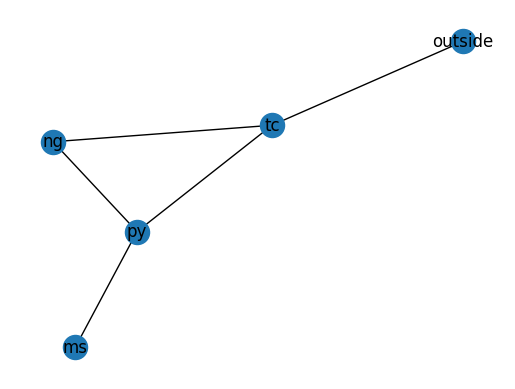

In [21]:
plt.axis("off")
pos = nx.spring_layout(topology_graph)
nx.draw_networkx_nodes(topology_graph, pos)
nx.draw_networkx_edges(topology_graph, pos)
nx.draw_networkx_labels(topology_graph, pos)
plt.show()

Save topology graph to file

In [ ]:
topology_graph_folder = os.path.join(result_folder, str(times))
topology_graph_path = os.path.join(topology_graph_folder, 'topology-graph.png')
plt.savefig(topology_graph_path, transparent=True)

---
### draw gateway graph

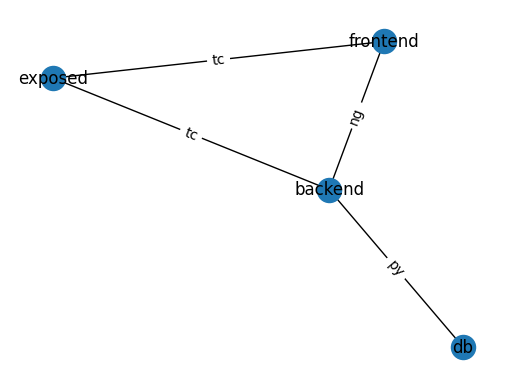

In [22]:
plt.axis("off")
pos = nx.spring_layout(gateway_graph)
nx.draw_networkx_nodes(gateway_graph, pos)
nx.draw_networkx_edges(gateway_graph, pos)
nx.draw_networkx_labels(gateway_graph, pos)
nx.draw_networkx_edge_labels(gateway_graph, pos, edge_labels=gateway_graph_labels)
plt.show()

Save gateway graph to file

In [ ]:
gateway_graph_folder = os.path.join(result_folder, str(times))
gateway_graph_path = os.path.join(gateway_graph_folder, 'gateway-graph.png')
plt.savefig(gateway_graph_path, transparent=True)

---
### Draw attack graph

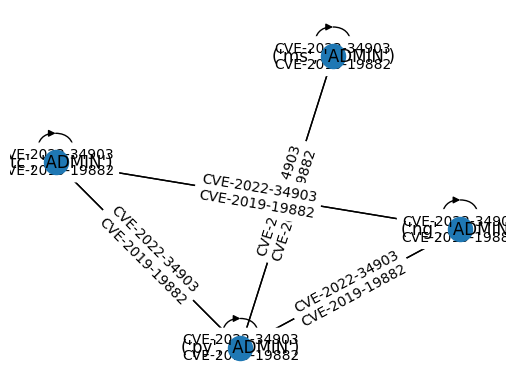

In [33]:
plt.axis("off")
pos = nx.spring_layout(composed_graph)
nx.draw_networkx_nodes(composed_graph, pos)
nx.draw_networkx_edges(composed_graph, pos)
nx.draw_networkx_labels(composed_graph, pos)
nx.draw_networkx_edge_labels(composed_graph, pos, edge_labels=composed_labels)
plt.show()

Save attack graph to file

In [ ]:
composed_graph_folder = os.path.join(result_folder, str(times))
composed_graph_path = os.path.join(composed_graph_folder, 'composed-graph.png')
plt.savefig(composed_graph_path, transparent=True)

---
### Draw a sub graph

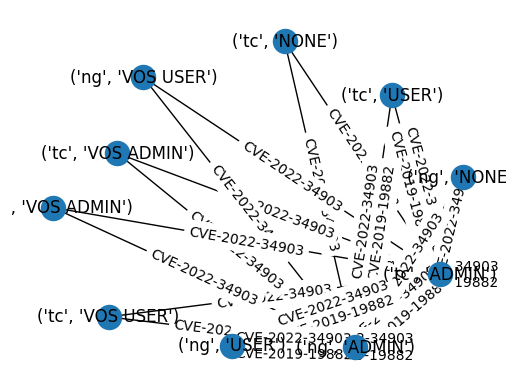

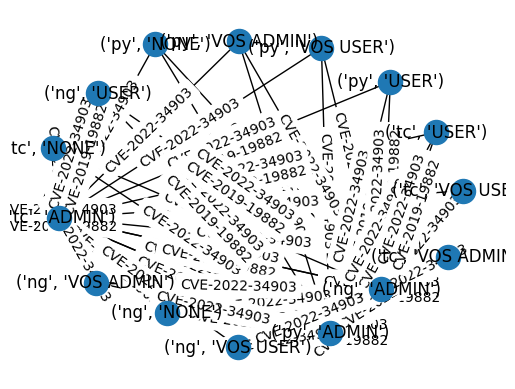

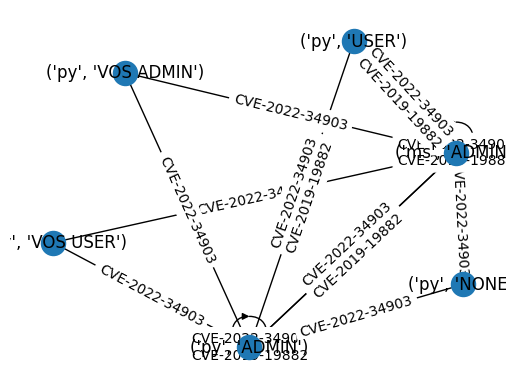

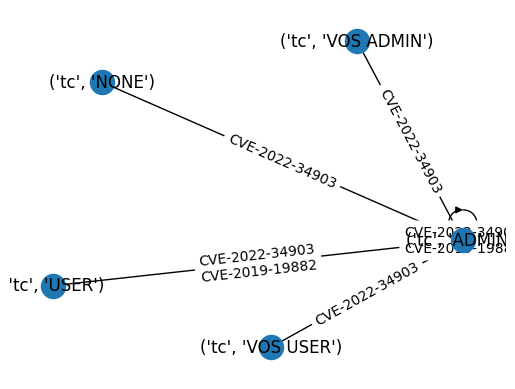

In [24]:
for network in networks:
    sub_graph = attack_graph[network]
    sub_labels = graph_labels[network]
    plt.axis("off")
    pos = nx.spring_layout(sub_graph)
    nx.draw_networkx_nodes(sub_graph, pos)
    nx.draw_networkx_edges(sub_graph, pos)
    nx.draw_networkx_labels(sub_graph, pos)
    nx.draw_networkx_edge_labels(sub_graph, pos, edge_labels=sub_labels)
    plt.show()

Save sub graph to file

In [ ]:
composed_graph_folder = os.path.join(result_folder, str(times))
composed_graph_path = os.path.join(composed_graph_folder, 'composed-graph.png')
plt.savefig(composed_graph_path, transparent=True)

---
### Generate example folders of full connections

In [ ]:
x = list(range(50, 1001, 50))
x.append([1, 5, 10])
for j in x:
    generate_full_conn(j)

---
### Add container to a network

In [ ]:
name = 'test'
image = 'nginx'
network = ['db', 'backend']

wrapper.add_node(config, example_folder, networks, services, topology_graph, gateway_graph, gateway_nodes, attack_graph, graph_labels, executor, gateway_graph_labels, image, network, name, vulnerabilities, exploitable_vulnerabilities, scores, attack_vectors, parsed_images)

---
### Delete container by name

In [ ]:
name = 'test'

affected_networks = services[name]['networks']

wrapper.del_node(networks, services, topology_graph, gateway_graph, attack_graph, config, graph_labels, executor, affected_networks, gateway_nodes, gateway_graph_labels, exploitable_vulnerabilities, scores, name)

---
### Generate honeypot defenses

In [ ]:
to = 'ms'
minimum = 3

def gen_defence_set(gateway_graph: nx.Graph, gateway_nodes: set[str], to: str, from_n='outside') -> list[str, int]:

    defense_set: set[str] = set()
    defense_set |= gateway_nodes
    path_counts = {}

    for path in nx.all_simple_paths(gateway_graph, from_n, to):
        for node in path:
            if node in path_counts:
                path_counts[node] = path_counts[node] + 1
            else:
                path_counts[node] = 1

    return sorted(path_counts.items())

wrapper.deploy_honeypot(config, example_folder, networks, services, topology_graph, gateway_graph, gateway_nodes, gateway_graph_labels, affected_networks, attack_graph, graph_labels, executor, vulnerabilities, exploitable_vulnerabilities, scores, parsed_images, attack_vectors, path_counts, minimum)

---
### Update attack graphs

In [ ]:
attack_graph_parser.update_by_networks(networks, attack_graph, graph_labels, exploitable_vulnerabilities, scores, executor, affected_networks, config['single-exploit-per-node'])